## STATS 170 Recapture in Python

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

1. Read-in the data

In [2]:
import pandas_datareader as web

/Users/yuangchen/opt/anaconda3/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [3]:
spy_data = web.DataReader('SPY', 'yahoo', "2018-01-01", "2019-01-01")

In [4]:
spy_data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2018-01-02,268.809998,267.399994,267.839996,268.769989,86655700.0,257.345001
2018-01-03,270.640015,268.959991,268.959991,270.470001,90070400.0,258.972717
2018-01-04,272.160004,270.540009,271.200012,271.609985,80636400.0,260.064240
2018-01-05,273.559998,271.950012,272.510010,273.420013,83524000.0,261.797302
2018-01-08,274.100006,272.980011,273.309998,273.920013,57319200.0,262.276093


In [5]:
spy_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 251 entries, 2018-01-02 to 2018-12-31
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   High       251 non-null    float64
 1   Low        251 non-null    float64
 2   Open       251 non-null    float64
 3   Close      251 non-null    float64
 4   Volume     251 non-null    float64
 5   Adj Close  251 non-null    float64
dtypes: float64(6)
memory usage: 13.7 KB


In [6]:
spy_data.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-16',
               ...
               '2018-12-17', '2018-12-18', '2018-12-19', '2018-12-20',
               '2018-12-21', '2018-12-24', '2018-12-26', '2018-12-27',
               '2018-12-28', '2018-12-31'],
              dtype='datetime64[ns]', name='Date', length=251, freq=None)

In [7]:
spy_data = spy_data.asfreq('B')

In [8]:
spy_data.index.inferred_freq

'B'

2. Check whether log/sqrt transformations stabilizes variance

Text(0.5, 1.0, 'SPY Close: Log')

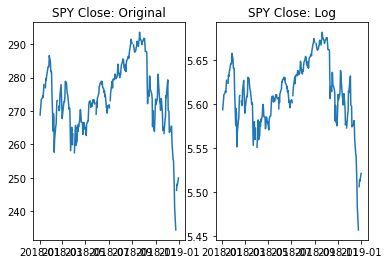

In [9]:
plt.subplot(121)
plt.plot(spy_data['Close'])
plt.title('SPY Close: Original')

plt.subplot(122)
plt.plot(np.log(spy_data['Close']))
plt.title('SPY Close: Log')

Text(0.5, 1.0, 'SPY Close: Square Root')

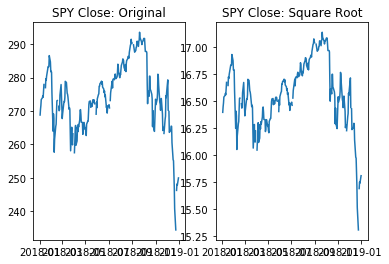

In [10]:
plt.subplot(121)
plt.plot(spy_data['Close'])
plt.title('SPY Close: Original')

plt.subplot(122)
plt.plot(np.sqrt(spy_data['Close']))
plt.title('SPY Close: Square Root')

3. Check ACFs after regular/seasonal differencing
    - We use the `shift()` method to shift the time-series and then create differences through subtraction.

In [11]:
reg_diff = spy_data['Close'] - spy_data['Close'].shift(1)
reg_diff.dropna(inplace=True)
reg_diff.head()

Date
2018-01-03    1.700012
2018-01-04    1.139984
2018-01-05    1.810028
2018-01-08    0.500000
2018-01-09    0.619995
Name: Close, dtype: float64

In [12]:
seas_diff = spy_data['Close'] - spy_data['Close'].shift(30)
seas_diff.dropna(inplace=True)
seas_diff.head()

Date
2018-02-13   -2.769989
2018-02-14   -0.880005
2018-02-15    1.420013
2018-02-16   -0.310028
2018-02-20   -3.140015
Name: Close, dtype: float64

In [13]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

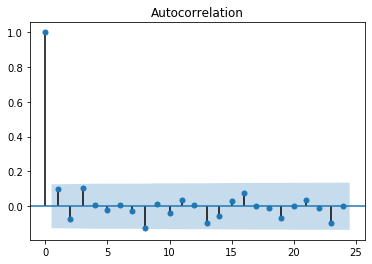

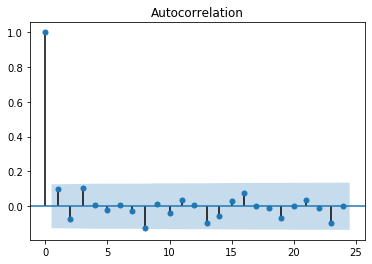

In [14]:
plot_acf(reg_diff)

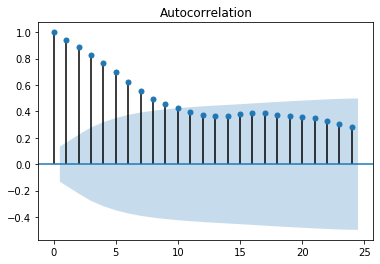

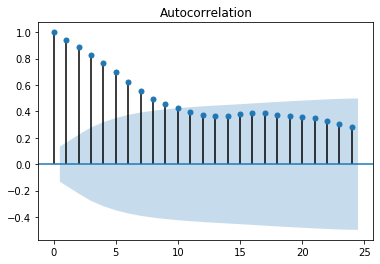

In [15]:
plot_acf(seas_diff)

In [16]:
seas_reg_diff = reg_diff - reg_diff.shift(30)
seas_reg_diff.dropna(inplace=True)
seas_reg_diff.head()

Date
2018-02-16   -1.620026
2018-02-21   -2.489990
2018-02-22   -1.460022
2018-02-23    3.809998
2018-02-26    2.570007
Name: Close, dtype: float64

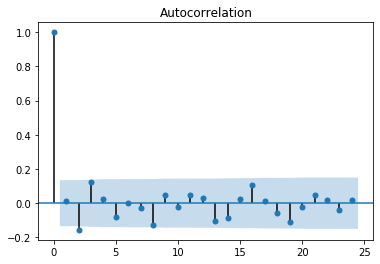

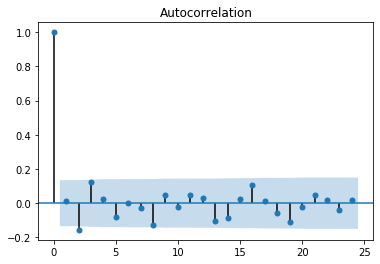

In [17]:
plot_acf(seas_reg_diff)

- From above, we move on with the `seas_reg_diff` data.
- Now, we plot out the PACF graph to identiy the appropriate model.

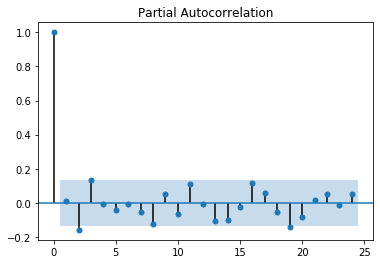

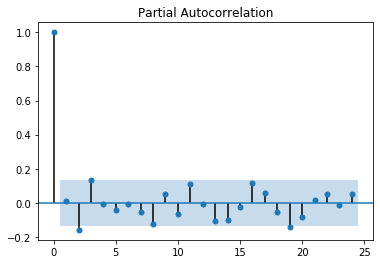

In [18]:
plot_pacf(seas_reg_diff)

4. Fit the model
    - Since it dies out quickly in both the ACF and PACF graphs, we fit the ARIMA model.
    - More specifially, we have:
        - Order of regular difference: 1
        - Order of seasonal difference: 1
        - AR(p) for regular part: 1
        - AR(p) for seasonal part: 0
        - MA(q) for regular part: 1
        - MA(q) for seasonal part: 0

In [19]:
import statsmodels.api as sm

In [20]:
model = sm.tsa.statespace.SARIMAX(spy_data['Close'], order=(1,1,1), seasonal_order=(0,1,0,30))

In [21]:
results = model.fit()

/Users/yuangchen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/yuangchen/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [22]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               Close   No. Observations:                  260
Model:             SARIMAX(1, 1, 1)x(0, 1, [], 30)   Log Likelihood                -596.968
Date:                             Thu, 28 May 2020   AIC                           1199.935
Time:                                     17:29:45   BIC                           1210.236
Sample:                                 01-02-2018   HQIC                          1204.091
                                      - 12-31-2018                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0002    283.703   5.64e-07      1.000    -556.047     556.047
ma.L1       5.219e-05    28

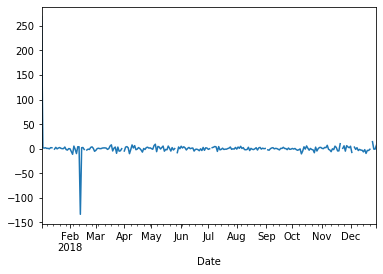

In [23]:
results.resid.plot()

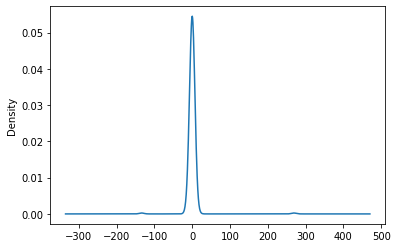

In [24]:
results.resid.plot(kind='kde')

5. Prediction
    - Let's first try in-sample predictions.

In [25]:
spy_data['Close: Forecasted'] = results.predict(start='2018-11-30', 
                                                end='2018-12-31', 
                                                dynamic=True)

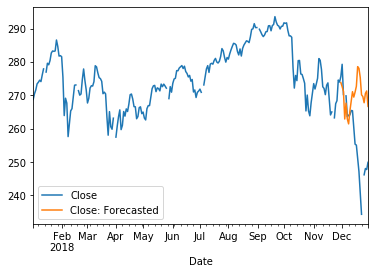

In [26]:
spy_data[['Close', 'Close: Forecasted']].plot()

- Now, let's see predictions for future dates.
    - First, we need to create the future dates and concate them onto the original dataframe.

In [27]:
from pandas.tseries.offsets import DateOffset

future_dates = [spy_data.index[-1] + DateOffset(days=x) for x in range(0, 32)]

In [28]:
future_dates

[Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-01 00:00:00'),
 Timestamp('2019-01-02 00:00:00'),
 Timestamp('2019-01-03 00:00:00'),
 Timestamp('2019-01-04 00:00:00'),
 Timestamp('2019-01-05 00:00:00'),
 Timestamp('2019-01-06 00:00:00'),
 Timestamp('2019-01-07 00:00:00'),
 Timestamp('2019-01-08 00:00:00'),
 Timestamp('2019-01-09 00:00:00'),
 Timestamp('2019-01-10 00:00:00'),
 Timestamp('2019-01-11 00:00:00'),
 Timestamp('2019-01-12 00:00:00'),
 Timestamp('2019-01-13 00:00:00'),
 Timestamp('2019-01-14 00:00:00'),
 Timestamp('2019-01-15 00:00:00'),
 Timestamp('2019-01-16 00:00:00'),
 Timestamp('2019-01-17 00:00:00'),
 Timestamp('2019-01-18 00:00:00'),
 Timestamp('2019-01-19 00:00:00'),
 Timestamp('2019-01-20 00:00:00'),
 Timestamp('2019-01-21 00:00:00'),
 Timestamp('2019-01-22 00:00:00'),
 Timestamp('2019-01-23 00:00:00'),
 Timestamp('2019-01-24 00:00:00'),
 Timestamp('2019-01-25 00:00:00'),
 Timestamp('2019-01-26 00:00:00'),
 Timestamp('2019-01-27 00:00:00'),
 Timestamp('2019-01-

In [29]:
future_dates_df = pd.DataFrame(index=future_dates[1:], columns=spy_data.columns)
spy_data_future = pd.concat([spy_data, future_dates_df])
spy_data_future.tail()

,High,Low,Open,Close,Volume,Adj Close,Close: Forecasted
2019-01-27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
spy_data_future.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2019-01-22', '2019-01-23', '2019-01-24', '2019-01-25',
               '2019-01-26', '2019-01-27', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', length=291, freq=None)

In [31]:
spy_data_future = spy_data_future.asfreq('B')

In [32]:
spy_data_future.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15',
               ...
               '2019-01-18', '2019-01-21', '2019-01-22', '2019-01-23',
               '2019-01-24', '2019-01-25', '2019-01-28', '2019-01-29',
               '2019-01-30', '2019-01-31'],
              dtype='datetime64[ns]', length=283, freq='B')

In [33]:
spy_data_future['Close: Forecasted'] = results.predict(start='2019-01-01', end='2019-01-30', dynamic=True)

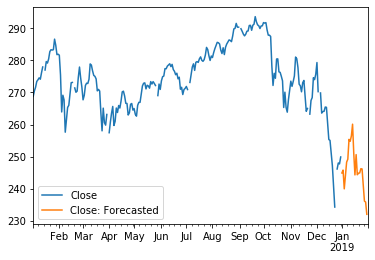

In [34]:
spy_data_future[['Close', 'Close: Forecasted']].plot()

6. Compare with the actual data

In [35]:
spy_data_future_real = web.DataReader('SPY', 'yahoo', '2019-01-01', '2019-01-30')

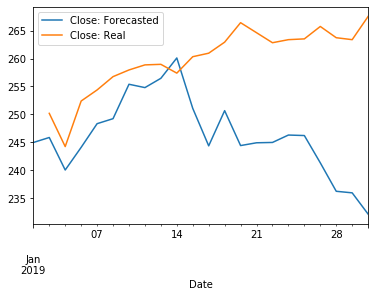

In [36]:
spy_data_future['Close: Forecasted']['2019-01-01':'2019-01-30'].plot(label='Close: Forecasted')
spy_data_future_real['Close'].plot(label='Close: Real')
plt.legend()